# Предварительная подготовка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [3]:
df = pd.read_csv('./data/digit.dat', sep = ';')
df.columns

Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'A2', 'B2', 'C2', 'D2', 'E2',
       'F2', 'G2', 'H2'],
      dtype='object')

In [101]:
mid = len(df.columns) // 2
df_01 = df.iloc[:, :mid]
df_01.head()

,A,B,C,D,E,F,G,H
0,seven,ONE,ZERO,ONE,ZERO,ZERO,ONE,ZERO
1,one,ZERO,ZERO,ONE,ZERO,ZERO,ONE,ZERO
2,four,ZERO,ONE,ONE,ONE,ZERO,ONE,ZERO
3,two,ONE,ONE,ONE,ONE,ONE,ZERO,ZERO
4,eight,ZERO,ONE,ONE,ONE,ONE,ONE,ONE


In [ ]:
# Уберем лишние пробелы в значениях

df_01 = df_01.map(lambda x: x.strip())

In [103]:
df_02 = df.iloc[:, mid:]
df_02.head()

,A2,B2,C2,D2,E2,F2,G2,H2
0,seven,ONE,ZERO,ONE,ZERO,ZERO,ONE,ZERO
1,one,ZERO,ZERO,ONE,ZERO,ZERO,ONE,ZERO
2,four,ZERO,ONE,ONE,ONE,ZERO,ONE,ZERO
3,two,ONE,ONE,ONE,ONE,ONE,ZERO,ZERO
4,eight,ZERO,ONE,ONE,ONE,ONE,ONE,ONE


In [104]:
# Посчитаем число различий в двух фреймах

diffs = 0
for row_01, row_02 in zip(df_01.itertuples(), df_02.itertuples()):
    diffs += row_01 != row_02
diffs

0

In [ ]:
# Их нет, поэтому будем работать с одним из них (df_01)
# Произведем замену: ZERO - 0, ONE - 1; а также для цифр

mapping = {
    'ZERO': 0, 'ONE': 1,
    'zero': 0, 'one': 1, 'two': 2, 'three': 3,
    'four': 4, 'five': 5, 'six': 6, 'seven': 7,
    'eight': 8, 'nine': 9, 'ten': 10
}

df_01 = df_01.replace(mapping).infer_objects(copy=False)
df_01.head()

C:\Users\mshsv\AppData\Local\Temp\ipykernel_18644\2088701120.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_01 = df_01.replace({'ZERO': 0, 'ONE': 1}).infer_objects(copy = False)
C:\Users\mshsv\AppData\Local\Temp\ipykernel_18644\2088701120.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_01 = df_01.replace({'zero': 0, 'one': 1, 'two': 2, 'three': 3,


,A,B,C,D,E,F,G,H
0,7,1,0,1,0,0,1,0
1,1,0,0,1,0,0,1,0
2,4,0,1,1,1,0,1,0
3,2,1,1,1,1,1,0,0
4,8,0,1,1,1,1,1,1


In [106]:
df = df_01
df_clear = df.drop(columns = 'A')

In [ ]:
# Функция для визулизации цифр

def digit_visual(df_mean, ncols = 3):
    height = 9
    width = 5
    
    horizontal = ["h" + str(i) for i in range(width)] * height
    vertical = ["v" + str(i) for i in range(height) for _ in range(width)]
    
    n_digits = len(df_mean)
    nrows = (n_digits + ncols - 1) // ncols
    
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize = (ncols * 2.5, nrows * 3),
        sharex = True, sharey = True
    )
    
    if nrows == 1:
        axes = axes.reshape(1, -1)
    if ncols == 1:
        axes = axes.reshape(-1, 1)

    for idx in range(n_digits):
        b = df_mean.iloc[idx]["B"]
        c = df_mean.iloc[idx]["C"]
        d = df_mean.iloc[idx]["D"]
        e = df_mean.iloc[idx]["E"]
        f = df_mean.iloc[idx]["F"]
        g = df_mean.iloc[idx]["G"]
        h = df_mean.iloc[idx]["H"]
        
        value = (
            [0, b, b, b, 0] +
            [c, 0, 0, 0, d] * 3 +
            [0, e, e, e, 0] +
            [f, 0, 0, 0, g] * 3 +
            [0, h, h, h, 0]
        )
        
        digit = pd.DataFrame({
            "h": horizontal,
            "v": vertical,
            "value": value,
        })
        led_digit = digit.pivot(index = "v", columns = "h", values = "value")
        
        row = idx // ncols
        col = idx % ncols
        
        sns.heatmap(
            led_digit,
            ax = axes[row, col],
            cmap = "Blues",
            xticklabels = False,
            yticklabels = False
        )

    for idx in range(n_digits, nrows * ncols):
        row = idx // ncols
        col = idx % ncols
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

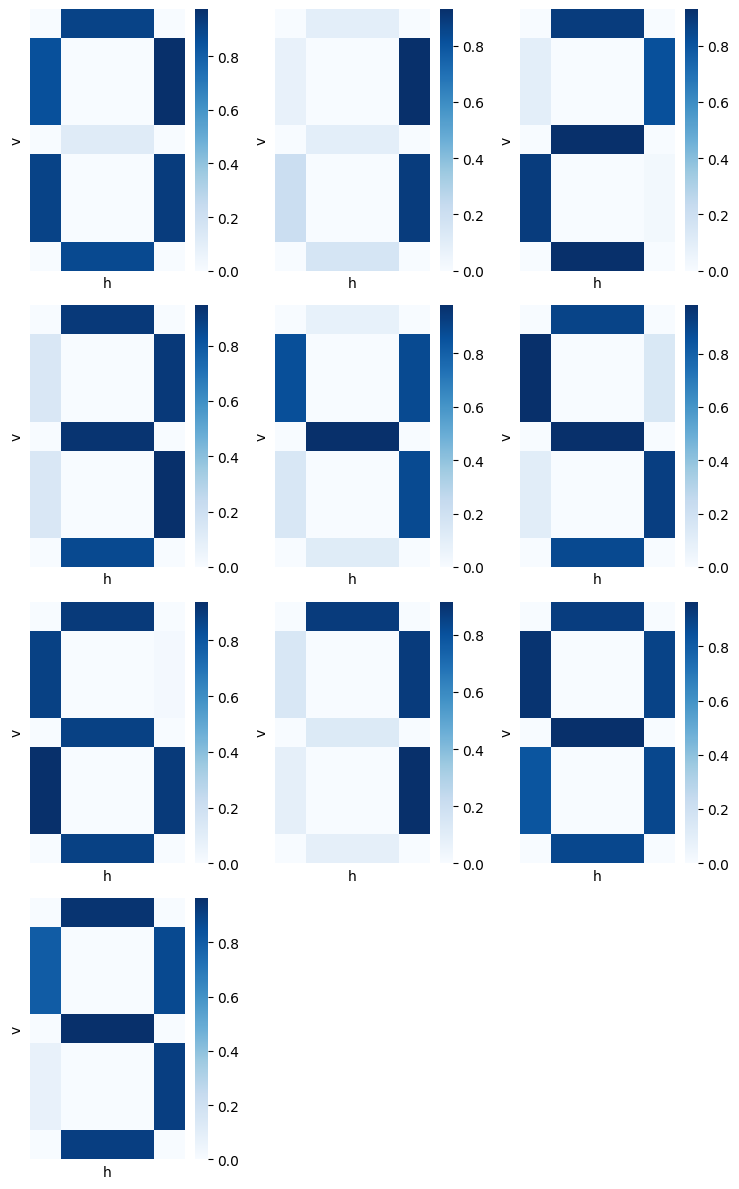

In [ ]:
# Визуализируем исходные данные

digit_visual(df.groupby('A').mean())

# Иерархический кластерный анализ

In [107]:
#  Кластеризуем
link = linkage(df_clear, 'ward', 'euclidean')
link.shape

(499, 4)

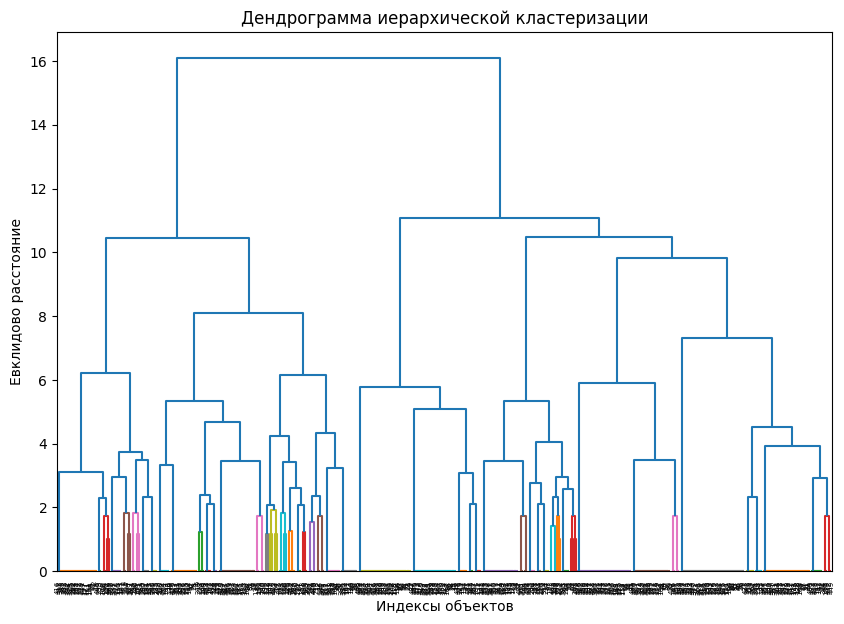

In [108]:
plt.figure(figsize = (10, 7))
dendrogram(link, color_threshold = 2)
plt.title('Дендрограмма иерархической кластеризации')
plt.xlabel('Индексы объектов')
plt.ylabel('Евклидово расстояние')
plt.show()

In [109]:
# Перебор значений t
t = None
t_vals = np.arange(2.0, 7.0, 0.2)
res = []

for val in t_vals:
    labels = fcluster(link, val, criterion = 'distance')
    if len(np.unique(labels)) == 10:
        res.append(val)
t = sum(res) / len(res)
t

np.float64(6.0000000000000036)

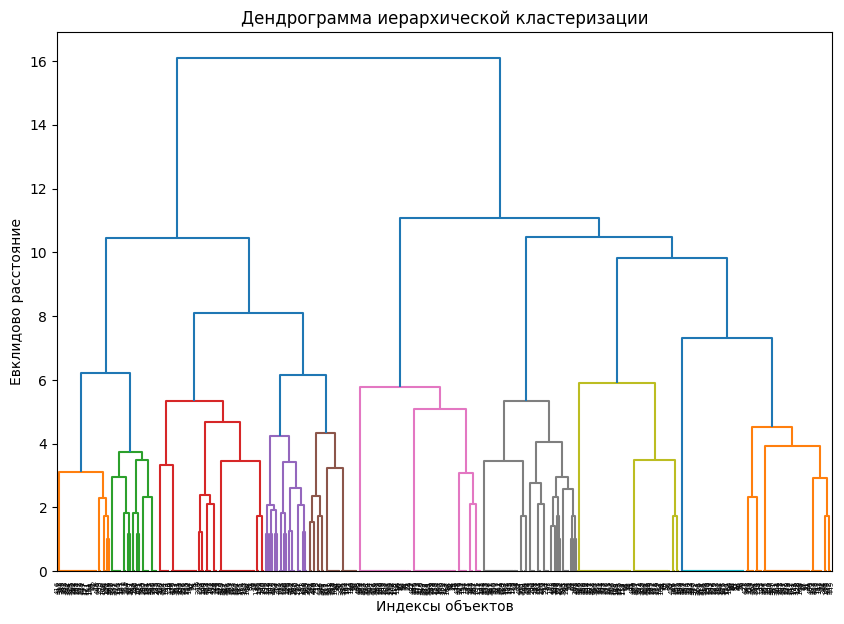

In [110]:
plt.figure(figsize = (10, 7))
dendrogram(link, color_threshold = t)
plt.title('Дендрограмма иерархической кластеризации')
plt.xlabel('Индексы объектов')
plt.ylabel('Евклидово расстояние')
plt.show()

In [111]:
df['fcluster'] = fcluster(link, t, criterion = 'distance')
df.head()

,A,B,C,D,E,F,G,H,fcluster
0,7,1,0,1,0,0,1,0,3
1,1,0,0,1,0,0,1,0,3
2,4,0,1,1,1,0,1,0,1
3,2,1,1,1,1,1,0,0,7
4,8,0,1,1,1,1,1,1,2


In [ ]:
# Число кластеров
len(df['fcluster'].unique())

10

In [112]:
df.groupby('A').mean()

,B,C,D,E,F,G,H,fcluster
A,,,,,,,,
0,0.904762,0.857143,0.976190,0.119048,0.904762,0.928571,0.880952,7.095238
1,0.093023,0.069767,0.930233,0.093023,0.209302,0.883721,0.162791,4.069767
2,0.883721,0.093023,0.813953,0.930233,0.883721,0.023256,0.930233,6.953488
3,0.909091,0.145455,0.909091,0.927273,0.145455,0.945455,0.854545,8.563636
4,0.076923,0.865385,0.884615,0.980769,0.153846,0.884615,0.115385,2.230769
5,0.907407,0.981481,0.148148,0.981481,0.111111,0.925926,0.888889,5.814815
6,0.900000,0.880000,0.020000,0.880000,0.940000,0.900000,0.880000,5.440000
7,0.875000,0.145833,0.875000,0.125000,0.083333,0.916667,0.083333,3.583333
8,0.913793,0.948276,0.896552,0.965517,0.827586,0.879310,0.879310,7.120690


In [113]:
df.groupby('fcluster').mean()

,A,B,C,D,E,F,G,H
fcluster,,,,,,,,
1,3.705882,0.029412,0.852941,1.000000,1.000000,0.000000,0.852941,0.000000
2,5.129032,0.000000,0.967742,0.548387,0.903226,0.548387,0.967742,0.806452
3,4.159420,0.507246,0.188406,1.000000,0.000000,0.115942,0.913043,0.057971
4,5.214286,0.785714,0.678571,0.000000,0.428571,0.428571,0.964286,0.214286
5,5.125000,1.000000,0.531250,1.000000,0.812500,0.343750,1.000000,0.000000
6,5.537500,1.000000,0.800000,0.000000,1.000000,0.475000,0.950000,1.000000
7,3.704918,0.836066,0.344262,0.754098,0.983607,0.754098,0.000000,0.885246
8,4.477612,1.000000,0.955224,1.000000,0.537313,1.000000,0.910448,1.000000
9,7.500000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000


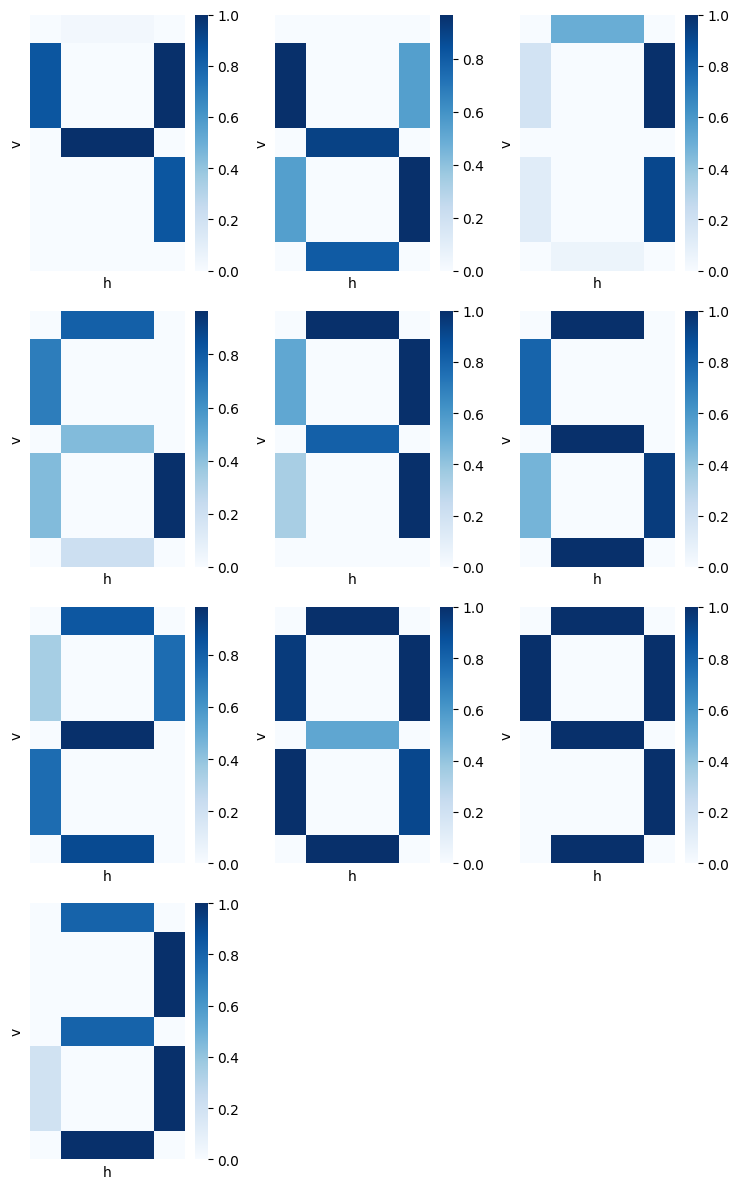

In [130]:
# Визуализируем данные, полученные в результате иерархической кластеризации

digit_visual(df.groupby('fcluster').mean())

# Кластерный анализ методом к-средних (k-means)

In [117]:
dist = []
clusters = [i for i in range(1, 30)]

for clust in clusters:

    clf = KMeans(n_clusters = clust, max_iter = 300, n_init = 10, random_state = 23)
    clf.fit(df_clear)
    dist.append(clf.inertia_)

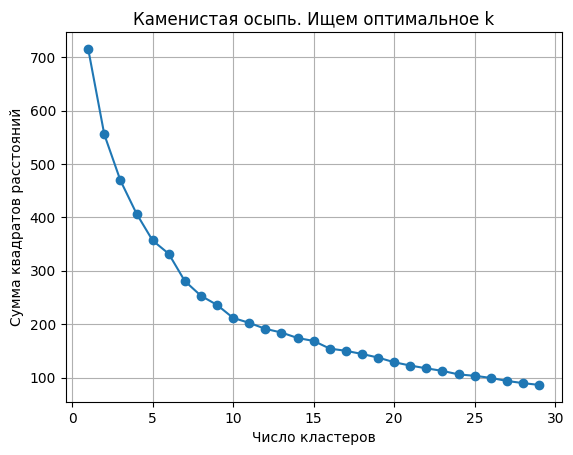

In [ ]:
# Строим график "каменистая осыпь"

plt.plot(clusters, dist, marker='o')
plt.grid(True)
plt.xlabel('Число кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Каменистая осыпь. Ищем оптимальное число кластеров')
plt.show()

In [ ]:
# ToDo
clusters = [i for i in range(2, 20)]
res = []
for clust in clusters:
    
    clf = KMeans(n_clusters = clust, random_state = 23)
    clf_labels = clf.fit_predict(df_clear)
    
    silhouette_avg = silhouette_score(df_clear, clf_labels)
    res.append(silhouette_avg)
    print(f"Число кластеров: {clust}, silhouette_score: {silhouette_avg}")

Число кластеров: 2, silhouette_score: 0.25244152536804043
Число кластеров: 3, silhouette_score: 0.2235760367679335
Число кластеров: 4, silhouette_score: 0.24600144137158694
Число кластеров: 5, silhouette_score: 0.24541259678705107
Число кластеров: 6, silhouette_score: 0.3029816330981956
Число кластеров: 7, silhouette_score: 0.3353547948190287
Число кластеров: 8, silhouette_score: 0.3956626899040474
Число кластеров: 9, silhouette_score: 0.4017213591813837
Число кластеров: 10, silhouette_score: 0.4367105526243606
Число кластеров: 11, silhouette_score: 0.44647226766407505
Число кластеров: 12, silhouette_score: 0.4690072934306705
Число кластеров: 13, silhouette_score: 0.475662304270168
Число кластеров: 14, silhouette_score: 0.48328127119947545
Число кластеров: 15, silhouette_score: 0.49451461280566095
Число кластеров: 16, silhouette_score: 0.5010780525570904
Число кластеров: 17, silhouette_score: 0.5076498863191641
Число кластеров: 18, silhouette_score: 0.5116123499180717
Число кластеров: 

In [133]:
clf = KMeans(n_clusters = 10, max_iter = 300, n_init = 10, random_state = 23)
clf.fit(df_clear)

KMeans(n_clusters=10, n_init=10, random_state=23)

In [134]:
counts, unique = np.unique(clf.labels_, return_counts = True)
pd.Series(unique, counts)

0    52
1    70
2    61
3    38
4    37
5    39
6    49
7    44
8    57
9    53
dtype: int64

In [136]:
df['KMeans'] = clf.labels_
df

,A,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
0,7,1,0,1,0,0,1,0,3,9,0
1,1,0,0,1,0,0,1,0,3,3,1
2,4,0,1,1,1,0,1,0,1,7,2
3,2,1,1,1,1,1,0,0,7,8,-1
4,8,0,1,1,1,1,1,1,2,8,-1
...,...,...,...,...,...,...,...,...,...,...,...
495,5,1,1,0,1,0,1,1,6,6,3
496,7,1,0,1,1,1,1,0,5,8,-1
497,4,0,0,1,1,1,0,0,7,5,-1
498,0,1,1,1,0,0,1,0,3,9,-1


In [137]:
df.groupby('KMeans').mean()

,A,B,C,D,E,F,G,H,fcluster,DBSCAN
KMeans,,,,,,,,,,
0,4.307692,0.884615,0.000000,0.807692,0.980769,0.000000,0.865385,1.000000,8.942308,4.961538
1,7.057143,0.871429,1.000000,1.000000,0.942857,0.000000,0.928571,0.842857,7.085714,2.600000
2,5.885246,0.852459,0.918033,0.000000,0.885246,1.000000,0.852459,0.803279,5.245902,2.803279
3,1.789474,0.000000,0.000000,0.894737,0.000000,0.236842,0.894737,0.157895,4.105263,-0.052632
4,0.810811,0.918919,0.918919,1.000000,0.000000,1.000000,0.891892,0.918919,7.432432,5.081081
5,2.358974,0.820513,0.000000,0.846154,0.923077,1.000000,0.000000,0.897436,6.974359,2.076923
6,5.265306,0.877551,1.000000,0.000000,0.959184,0.000000,0.959184,0.918367,5.306122,1.857143
7,3.818182,0.000000,0.840909,0.931818,0.909091,0.090909,0.886364,0.000000,1.590909,0.772727
8,6.614035,0.947368,0.824561,1.000000,1.000000,1.000000,0.912281,0.894737,7.614035,3.421053


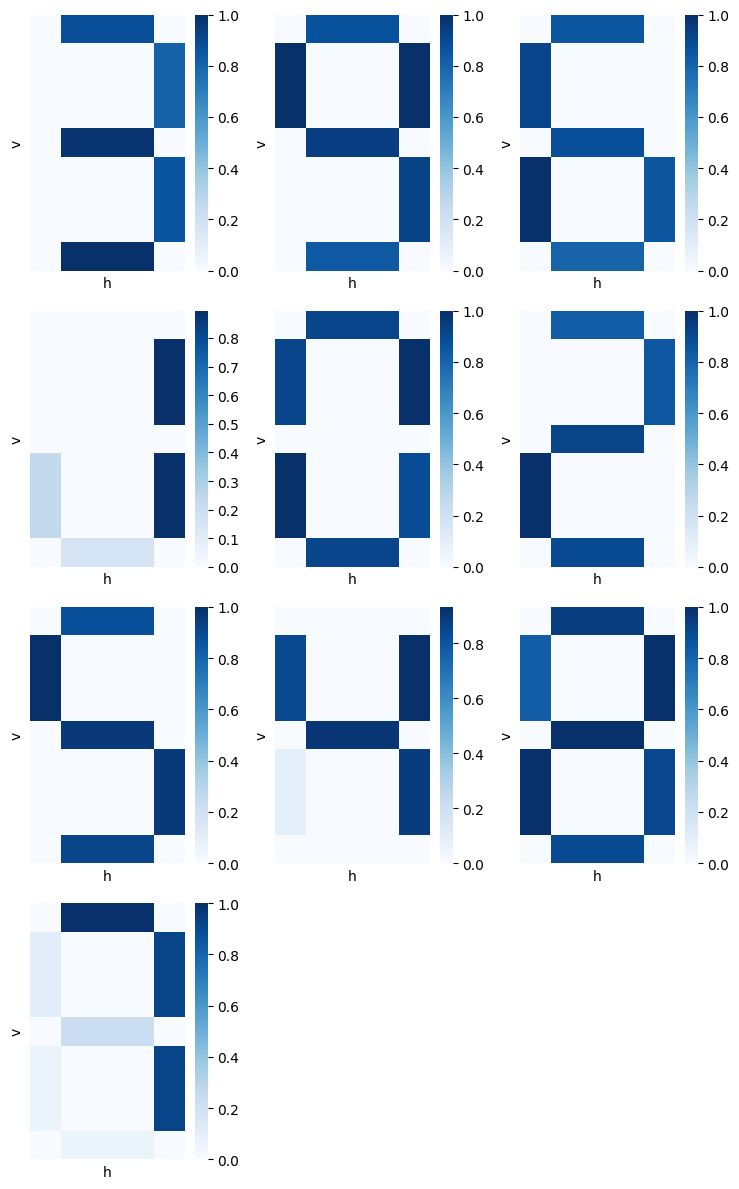

In [ ]:
# Визуализируем данные, полученные в результате кластеризации k-means

digit_visual(df.groupby('KMeans').mean())

# Кластерный анализ методом DBSCAN

In [139]:
clf = DBSCAN(eps = 0.9, metric = 'euclidean', min_samples = 12, algorithm = 'auto')
clf.fit(df_clear)

DBSCAN(eps=0.9, min_samples=12)

In [140]:
counts, unique = np.unique(clf.labels_, return_counts = True)
pd.Series(unique, counts)

-1    210
 0     24
 1     18
 2     26
 3     35
 4     24
 5     42
 6     36
 7     29
 8     25
 9     31
dtype: int64

In [141]:
df['DBSCAN'] = clf.labels_
df

,A,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
0,7,1,0,1,0,0,1,0,3,9,0
1,1,0,0,1,0,0,1,0,3,3,1
2,4,0,1,1,1,0,1,0,1,7,2
3,2,1,1,1,1,1,0,0,7,8,-1
4,8,0,1,1,1,1,1,1,2,8,-1
...,...,...,...,...,...,...,...,...,...,...,...
495,5,1,1,0,1,0,1,1,6,6,3
496,7,1,0,1,1,1,1,0,5,8,-1
497,4,0,0,1,1,1,0,0,7,5,-1
498,0,1,1,1,0,0,1,0,3,9,-1


In [142]:
df.groupby('DBSCAN').mean()

,A,B,C,D,E,F,G,H,fcluster,KMeans
DBSCAN,,,,,,,,,,
-1,4.409524,0.614286,0.504762,0.652381,0.666667,0.457143,0.714286,0.533333,5.12381,4.352381
0,6.750000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3.00000,9.000000
1,1.666667,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3.00000,3.000000
2,3.884615,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.00000,7.000000
3,5.400000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,6.00000,6.000000
4,2.208333,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,7.00000,5.000000
5,7.500000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,9.00000,1.000000
6,7.444444,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.00000,8.000000
7,5.931034,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,6.00000,2.000000


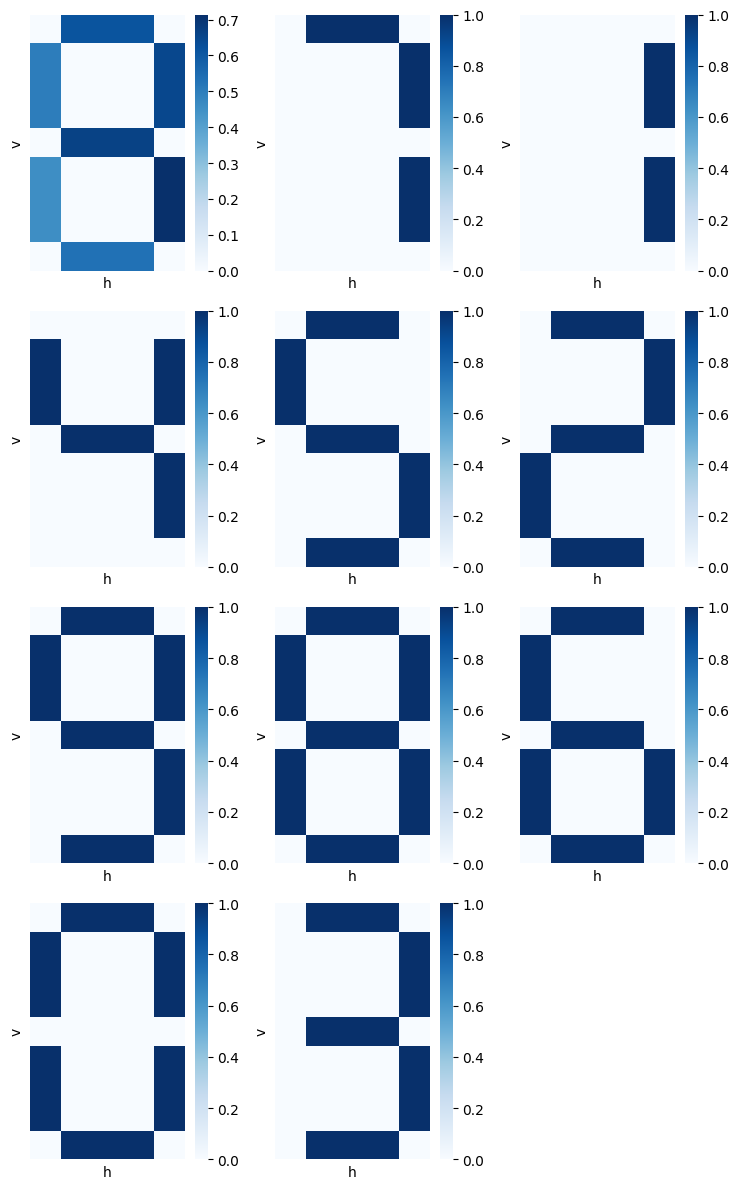

In [143]:
# Визуализируем данные, полученные в результате кластеризации dbscan

digit_visual(df.groupby('DBSCAN').mean())